# B1

In [5]:
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
import arviz
from matplotlib import pyplot as plt
import numpy as np

In [2]:
pyro.set_rng_seed(1028)
pyro.clear_param_store()
# Define the data set
x = torch.tensor([-1, -0.5, 0, 0.5, 1])
y = torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)

# Define the Gaussian RBM kernel using the RBF method and the sampled lengthscale and variance
rbm_kernel = gp.kernels.RBF(input_dim = 1)
rbm_kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0, 2))
rbm_kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1, 1))

# Define the GP prior using the specified mean function and kernel
gpr = gp.models.GPRegression(x, y, rbm_kernel, noise=torch.tensor(1e-4))

In [3]:
n_chains = 2
n_warmup = 2000
n_samples_per_chain = 10000
n_samples = n_chains * n_samples_per_chain

In [4]:
## Draw samples with NUTS
nuts_kernel = pyro.infer.mcmc.NUTS(gpr.model)

mcmc = pyro.infer.mcmc.MCMC(nuts_kernel, warmup_steps = n_warmup, num_samples = n_samples_per_chain, num_chains = n_chains)

mcmc.run()

samples = mcmc.get_samples()

Warmup [1]:   0%|          | 0/12000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/12000 [00:00, ?it/s]

/home/adam/.miniconda3/envs/my_pyro/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


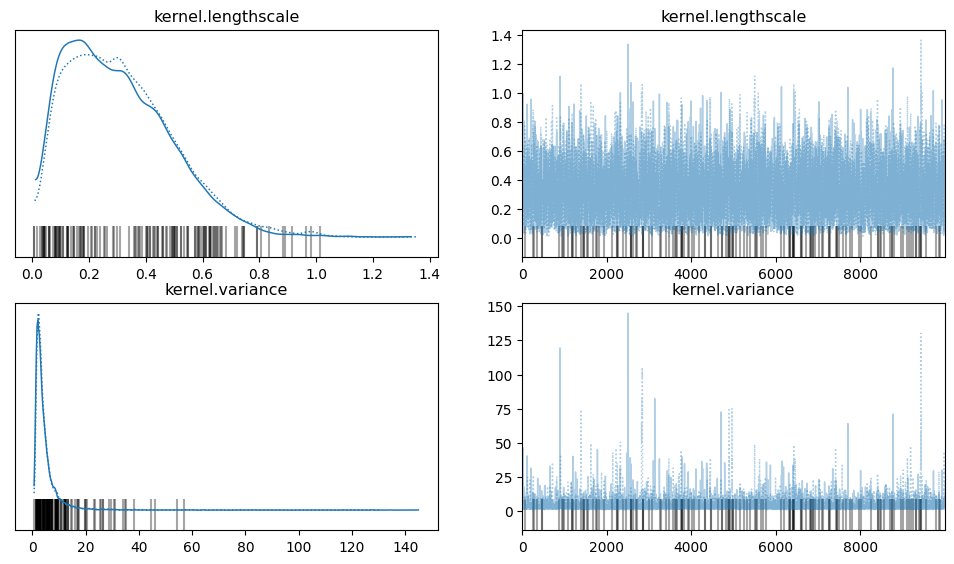

In [7]:
## Check trace plots with arviz
arviz_data = arviz.from_pyro(mcmc, num_chains = n_chains)
axes = arviz.plot_trace(arviz_data, figsize = (12, 6.5))

In [8]:
fig = axes.ravel()[0].figure
fig.savefig('figures/b1_traceplots.png', format='png', dpi=1200)

In [9]:
## Cheack r_hat and ess with arviz
arviz.summary(arviz_data, hdi_prob = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.lengthscale,0.310,0.184,0.022,0.652,0.003,0.002,3944.0,5029.0,1.0
kernel.variance,4.863,6.521,0.666,12.557,0.148,0.109,4946.0,3382.0,1.0


We get r_hat = 1.0 for both parameters, which indicates convergence of the chains. The number of effective sample sizes (ess_bulk) is 951 for lengthscale and 1176 for variance - this should be adequate for our needs and is well over the recommended minimum of 400.

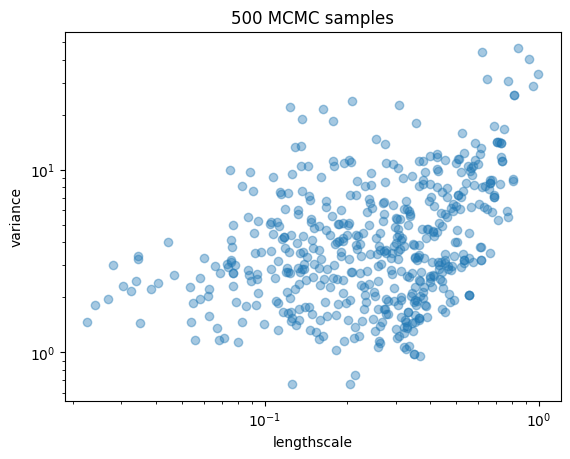

In [10]:
## Plot of first 500 MCMC samples in log-log plot as requested
lengthscale_samples_500 = samples["kernel.lengthscale"][0:500]
variance_samples_500 = samples["kernel.variance"][0:500]

fig = plt.figure()
plt.loglog(lengthscale_samples_500, variance_samples_500, 'o', alpha = 0.4)
plt.xlabel('lengthscale')
plt.ylabel('variance')
plt.title("500 MCMC samples")
plt.show()
fig.savefig('figures/b1_500_samples.png', format='png', dpi=1200)

In [11]:
n_x_new = 200
x_new = torch.linspace(-1, 1, steps = n_x_new)
f_samples = torch.empty(n_samples, n_x_new)
m_samples = torch.empty(n_samples, n_x_new)
v_samples = torch.empty(n_samples, n_x_new)

In [12]:
for i in range(n_samples):
    pyro.clear_param_store()
    lengthscale_sample = samples["kernel.lengthscale"][i]
    variance_sample = samples["kernel.variance"][i]
    rbm_kernel_sample = gp.kernels.RBF(input_dim = 1, variance = variance_sample, lengthscale = lengthscale_sample)
    gpr_sample = gp.models.GPRegression(x, y, rbm_kernel_sample, noise=torch.tensor(1e-4))
    # noiseless = True since we are interested in the Gaussian process f and not the observations y
    m_sample, v_sample = gpr_sample(x_new, full_cov = False, noiseless = True)
    f_dist = dist.MultivariateNormal(m_sample, covariance_matrix=torch.diag(v_sample))
    f_sample = f_dist.sample()
    f_samples[i, :] = f_sample
    m_samples[i, :] = m_sample
    v_samples[i, :] = v_sample

In [13]:
f_posterior_mean = f_samples.mean(dim = 0)
f_posterior_var = f_samples.var(dim = 0)
m_mean = m_samples.mean(dim = 0)
v_mean = v_samples.mean(dim = 0)

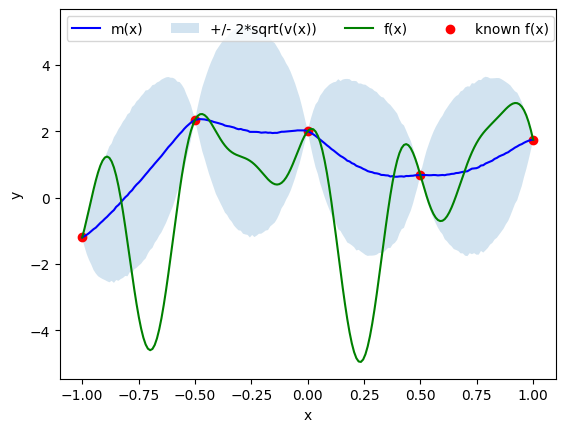

In [17]:
# Extract values from tensors
f_posterior_mean_values = f_posterior_mean.detach().numpy()
f_posterior_var_values = f_posterior_var.detach().numpy()
m_mean_values = m_mean.detach().numpy()
v_mean_values = v_mean.detach().numpy()
x_new_values = x_new.detach().numpy()
y_values = y.detach().numpy()
x_values = x.detach().numpy()
f_values = np.sin(20 * x_new_values) + 2 * np.cos(14 * x_new_values) - 2 * np.sin(6 * x_new_values)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_new_values, f_posterior_mean_values, c='b')
plt.fill_between(x_new_values,
                 f_posterior_mean_values - 2 * np.sqrt(f_posterior_var_values),
                 f_posterior_mean_values + 2 * np.sqrt(f_posterior_var_values),
                 alpha=0.2)
ax.plot(x_new_values, f_values, c='g')
ax.scatter(x_values, y_values, c='r', marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(['m(x)', '+/- 2*sqrt(v(x))', 'f(x)', 'known f(x)'],
          loc = "upper left", ncol = 4)
plt.show()
fig.savefig('figures/b1_m_and_v.png', format='png', dpi=1200)